In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import cross_val_score, train_test_split
from time import time
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [2]:
def subsample_flatten(df, sample_rate = 1):
    arr = df.to_numpy()
    flat_ls = []
    for i, sample in enumerate(arr):
        if sample[0][-5:] == '05:00':
            humidity = arr[i-59,-1]
            flat_ls.append(arr[i-59:i+1,1:-1])
            flat_ls[-1] = flat_ls[-1][::sample_rate].flatten('F')
            flat_ls[-1] = np.append(flat_ls[-1], humidity)
            flat_ls[-1] = np.insert(flat_ls[-1], 0, sample[0], axis = 0)
    return pd.DataFrame(np.vstack(flat_ls))

In [3]:
def get_x_y(df_x, df_y, sample_rate):
    flat_df = subsample_flatten(df_x, sample_rate)
    flat_df.rename(columns={0:'date_time'}, inplace=True)
    flat_df['date_time'] = pd.to_datetime(flat_df['date_time'])
    df_y['date_time'] = pd.to_datetime(df_y['date_time'])
    merged_df = pd.merge(flat_df, df_y, on='date_time', how="inner")
    y_vals = merged_df['quality']
    x_vals = merged_df.drop(['date_time', 'quality'], axis = 1)
    x_vals = x_vals.apply(pd.to_numeric)
    return x_vals, y_vals

In [4]:
def make_inputs(df_x, start, num_inputs, sample_rate):
    flat_ls = []
    df_x = df_x.drop(df_x.columns[[0]], axis = 1)
    for i in range(start, start + num_inputs, 1):
        sub_df = df_x.iloc[i:i+60]
        arr = sub_df.to_numpy()
        humidity = arr[0,-1]
        arr = arr[:,:-1]
        flat_ls.append(arr[::sample_rate].flatten('F'))
        flat_ls[-1] = np.append(flat_ls[-1], humidity)
    return pd.DataFrame(flat_ls)

In [5]:
def make_inputs_per_hr(df_x, start, num_inputs, sample_rate):
    flat_ls = []
    df_x = df_x.drop(df_x.columns[[0]], axis = 1)
    for i in range(start, start + num_inputs, 60):
        sub_df = df_x.iloc[i:i+60]
        arr = sub_df.to_numpy()
        humidity = arr[0,-1]
        arr = arr[:,:-1]
        flat_ls.append(arr[::sample_rate].flatten('F'))
        flat_ls[-1] = np.append(flat_ls[-1], humidity)
    return pd.DataFrame(flat_ls)

In [6]:
df_x = pd.read_csv("archive/data_x.csv")
df_y = pd.read_csv("archive/data_y.csv")

In [7]:
df_x.drop(index=df_x.index[:6], axis=0, inplace=True)
df_x.drop(df_x.columns[[10,11,12,17]], axis = 1, inplace = True)

In [8]:
print(np.min(df_y['quality']),np.max(df_y['quality']))

221 505


In [11]:
# Without ordered test
sample_rate = 3

x_vals, y_vals = get_x_y(df_x, df_y, sample_rate)

x_train, x_test, y_train, y_test = train_test_split(x_vals, y_vals, test_size = 0.2)
x_train_np = np.array(x_train)
x_test_np = np.array(x_test)
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

In [14]:
# With ordered test
sample_rate = 3
n = 0.02

x_vals, y_vals = get_x_y(df_x, df_y, sample_rate)

n *= len(x_vals)
n = int(n)

x_ordered_test, y_ordered_test = x_vals[-n:], y_vals[-n:]

x_vals, y_vals = x_vals[:-n], y_vals[:-n]

x_train, x_test, y_train, y_test = train_test_split(x_vals, y_vals, test_size = 0.2)
x_train_np = np.array(x_train)
x_test_np = np.array(x_test)
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

In [12]:
# Sample 3
best_params = {'colsample_bytree': 1.0,
    'learning_rate': 0.01,
    'max_depth': 12,
    'min_child_weight': 47.4166539630296,
    'n_estimators': 5000,
    'subsample': 0.6412569205196084}

In [13]:
xgb_model = xgb.XGBRegressor()
xgb_model.set_params(**best_params)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=47.4166539630296, missing=nan,
             monotone_constraints=None, n_estimators=5000, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None, ...)

In [14]:
xgb_model.fit(x_train_np, y_train_np)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=12, max_leaves=0, min_child_weight=47.4166539630296,
             missing=nan, monotone_constraints='()', n_estimators=5000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [15]:
print(f'R2 score = {round(xgb_model.score(x_test_np, y_test_np),5)}')
y_pred = xgb_model.predict(x_test_np)
start = time()
xgb_model.predict(x_test_np[:1])
time_to_predict = time() - start
print(f"Took {round(time_to_predict,4)} seconds to make prediction on a single input test")
start = time()
cv = cross_val_score(xgb.XGBRegressor(**best_params), x_train_np, y_train_np, cv = 3, scoring = ('neg_root_mean_squared_error'))
time_to_validate = time() - start
print(f"Took {round(time_to_validate,4)} seconds to validate")
rmse = round(np.abs(cv.mean()),2)
print(f'CV RMSE = {rmse}')
print(f'Root mean squared error from test set = {round(math.sqrt(mean_squared_error(y_test_np, y_pred)),2)}')
print(f'Mean absolute error from test set = {round(mean_absolute_error(y_test_np, y_pred),2)}')
print(f'Mean absolute percentage error from test set = {round(mean_absolute_percentage_error(y_test_np, y_pred),4)}')

R2 score = 0.96355
Took 0.005 seconds to make prediction on a single input test
Took 0.005 seconds to validate
CV RMSE = 9.15
CV MAE = 6.66
Root mean squared error from test set = 8.89
Mean absolute error from test set = 6.5
Mean absolute error from test set = 0.0169


In [16]:
print(time_to_validate)

970.297447681427


In [17]:
print(round(mean_absolute_percentage_error(y_test_np, y_pred),4)*100)

1.69


In [22]:
# With ordered test
sample_rate = 3
n = 0.02

x_vals, y_vals = get_x_y(df_x, df_y, sample_rate)

n *= len(x_vals)
n = int(n)

x_ordered_test, y_ordered_test = x_vals[-n:], y_vals[-n:]

x_vals, y_vals = x_vals[:-n], y_vals[:-n]

x_train, x_test, y_train, y_test = train_test_split(x_vals, y_vals, test_size = 0.2)
x_train_np = np.array(x_train)
x_test_np = np.array(x_test)
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

In [23]:
xgb_model = xgb.XGBRegressor()
xgb_model.set_params(**best_params)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=47.4166539630296, missing=nan,
             monotone_constraints=None, n_estimators=5000, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None, ...)

In [24]:
xgb_model.fit(x_train_np, y_train_np)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=12, max_leaves=0, min_child_weight=47.4166539630296,
             missing=nan, monotone_constraints='()', n_estimators=5000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [25]:
print(f'R2 score = {round(xgb_model.score(x_test_np, y_test_np),5)}')
y_pred = xgb_model.predict(x_test_np)
start = time()
xgb_model.predict(x_test_np[:1])
time_to_predict = time() - start
print(f"Took {round(time_to_predict,4)} seconds to make prediction on a single input test")
start = time()
cv = cross_val_score(xgb.XGBRegressor(**best_params), x_train_np, y_train_np, cv = 3, scoring = ('neg_root_mean_squared_error'))
time_to_validate = time() - start
print(f"Took {round(time_to_validate,4)} seconds to validate")
rmse = round(np.abs(cv.mean()),2)
print(f'CV RMSE = {rmse}')
print(f'Root mean squared error from test set = {round(math.sqrt(mean_squared_error(y_test_np, y_pred)),2)}')
print(f'Mean absolute error from test set = {round(mean_absolute_error(y_test_np, y_pred),2)}')
print(f'Mean absolute percentage error from test set = {round(mean_absolute_percentage_error(y_test_np, y_pred),4)}')

R2 score = 0.96396
Took 0.003 seconds to make prediction on a single input test
Took 908.2514 seconds to validate
CV RMSE = 9.11
Root mean squared error from test set = 8.86
Mean absolute error from test set = 6.44
Mean absolute percentage error from test set = 0.0167


In [79]:
#hr_to_offset = 110
#hr_to_offset = 30
#hr_to_offset = 90
hr_to_offset = 110
num_hrs = 12
num_inputs = 60*num_hrs
# Must be at least 4319 because this is where the y_vals starts being recorded
start = 4319
offset = (hr_to_offset)*1000
start += offset
inputs = make_inputs(df_x, start, num_inputs, sample_rate)
predictions = xgb_model.predict(inputs)

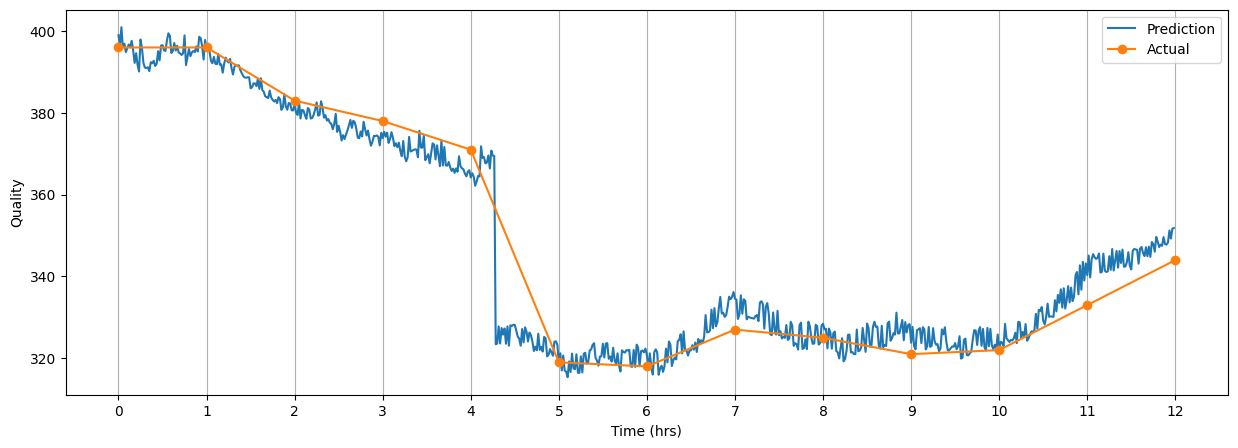

In [80]:
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0, num_inputs + 1, 60)
ax.set_xticks(major_ticks, range(len(major_ticks)))
ax.plot(range(len(predictions)), predictions, label = 'Prediction')

num_hrs = int(round(num_inputs/60)) + 2
s = int(round((offset)/60))
qualities = y_vals.iloc[s+1:s + num_hrs]
hrs = [i*60 for i in range(len(qualities))]

ax.plot(hrs, qualities, label = 'Actual', marker = 'o')


ax.legend()
ax.set_ylabel('Quality')
ax.set_xlabel('Time (hrs)')
#ax.set_title('Per min prediction vs Per hr training data')
ax.grid(which='major', axis = 'x')

In [22]:
inputs_per_hr = make_inputs_per_hr(df_x, start, num_inputs, sample_rate)
predictions_per_hr = xgb_model.predict(inputs_per_hr)

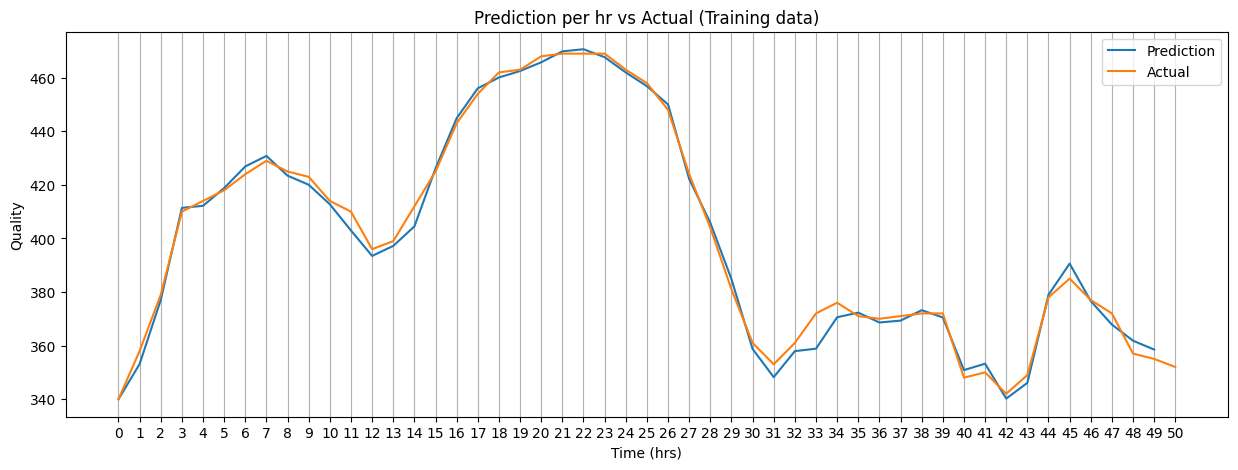

In [23]:
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0, num_inputs + 1, 60)
ax.set_xticks(major_ticks, range(len(major_ticks)))
ax.plot([i*60 for i in range(len(predictions_per_hr))], predictions_per_hr, label = 'Prediction')

num_hrs = int(round(num_inputs/60)) + 2
s = int(round((offset)/60))
qualities = y_vals.iloc[s+1:s + num_hrs]
hrs = [i*60 for i in range(len(qualities))]

ax.plot(hrs, qualities, label = 'Actual')


ax.legend()
ax.set_ylabel('Quality')
ax.set_xlabel('Time (hrs)')
ax.set_title('Prediction per hr vs Actual (Training data)')
ax.grid(which='major', axis = 'x')

In [36]:
print(f'R2 score = {round(xgb_model.score(x_test_np, y_test_np),5)}')
y_pred = xgb_model.predict(x_test_np)
start = time()
xgb_model.predict(x_test_np[:1])
time_to_predict = time() - start
print(f"Took {round(time_to_predict,4)} seconds to make prediction on a single input test")
cv = cross_val_score(xgb.XGBRegressor(**best_params), x_train_np, y_train_np, cv = 3, scoring = ('neg_root_mean_squared_error'))
rmse = round(np.abs(cv.mean()),2)
mae_cv = cross_val_score(xgb.XGBRegressor(**best_params), x_train_np, y_train_np, cv = 3, scoring = ('neg_mean_absolute_error'))
mae = round(np.abs(mae_cv.mean()),2)
print(f'CV RMSE = {rmse}')
print(f'CV MAE = {mae}')
print(f'Root mean squared error from test set = {round(math.sqrt(mean_squared_error(y_test_np, y_pred)),2)}')
print(f'Mean absolute error from test set = {round(mean_absolute_error(y_test_np, y_pred),2)}')

R2 score = 0.96434
Took 0.003 seconds to make prediction on a single input test
CV RMSE = 9.14
CV MAE = 6.67
Root mean squared error from test set = 8.67
Mean absolute error from test set = 6.35


C:\Users\robbi\AppData\Local\Temp\ipykernel_16620\14709203.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax.plot(range(len(ordered_pred)), y_ordered_test[:n_points], label = 'Actual')


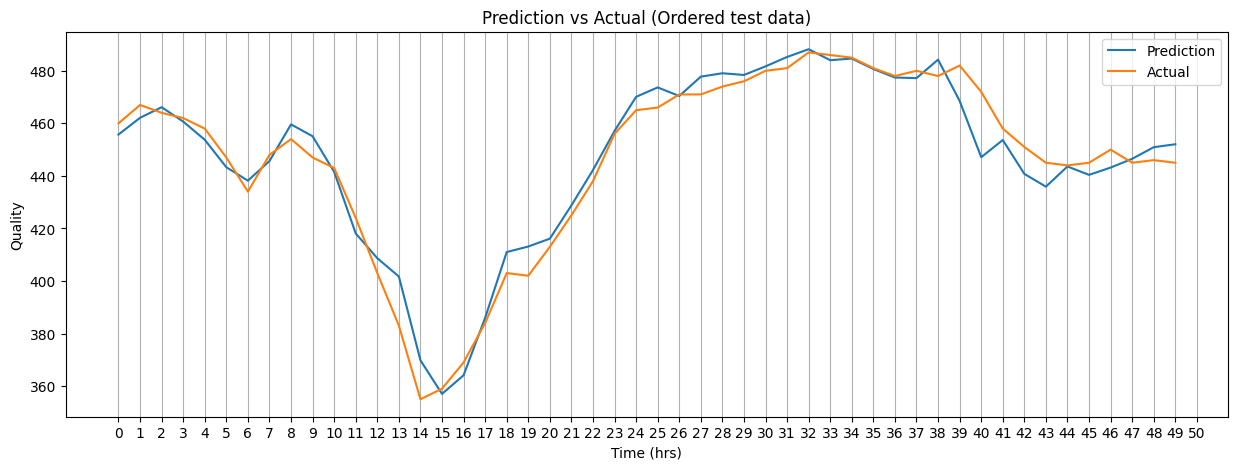

In [37]:
n_points = 50

ordered_pred = xgb_model.predict(x_ordered_test[:n_points])

fig = plt.figure(figsize = (15,5))

ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0, len(ordered_pred) + 1, 1)
ax.set_xticks(major_ticks, range(len(major_ticks)))

ax.plot(range(len(ordered_pred)), ordered_pred, label = 'Prediction')
ax.plot(range(len(ordered_pred)), y_ordered_test[:n_points], label = 'Actual')

ax.legend()
ax.set_ylabel('Quality')
ax.set_xlabel('Time (hrs)')
ax.set_title('Prediction vs Actual (Ordered test data)')
ax.grid(which='major', axis = 'x')